# Dataset 

https://www.kaggle.com/mariaren/covid19-healthy-diet-dataset

# Problem definition 

We chose a dataset combining different types of food, world population obesity and undernourished rate, and global covid cases count from around the world.

The idea is to understand how a healthy eating style could help combat the coronavirus, distinguishing the diet patterns from countries with lower COVID infection rate.

Our goal here is to provide diet recommendations based on our findings.

Each dataset provides different diet measure different categories of food, depending on what we want to focus on, so we have

- fat quantity,
- energy intake (kcal),
- food supply quantity (kg),
- protein for different categories of food

To which have been added:

- obesity rate
- undernourished rate
- the most up to date confirmed/deaths/recovered/active cases.

We are going to focus on the fat quantity dataset.

In [13]:
%matplotlib inline
from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px

from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression, Ridge,  Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics

from sklearn.datasets import load_iris
from sklearn import tree

In [14]:
import os
os.environ["OMP_NUM_THREADS"] = '1'

Let's start by loading the data

In [15]:
df = pd.read_csv("./data/Fat_Supply_Quantity_Data.csv", sep=',')
# df.Undernourished = pd.to_numeric(df.Undernourished, errors='coerce')
# df.iloc[:, 1:30] = df.drop(columns=['Country','Population','Unit (all except Population)']).apply(transform_from_perc)
df = df.drop(columns=['Unit (all except Population)'])

array([[<Axes: title={'center': 'Alcoholic Beverages'}>,
        <Axes: title={'center': 'Animal Products'}>,
        <Axes: title={'center': 'Animal fats'}>,
        <Axes: title={'center': 'Aquatic Products, Other'}>,
        <Axes: title={'center': 'Cereals - Excluding Beer'}>],
       [<Axes: title={'center': 'Eggs'}>,
        <Axes: title={'center': 'Fish, Seafood'}>,
        <Axes: title={'center': 'Fruits - Excluding Wine'}>,
        <Axes: title={'center': 'Meat'}>,
        <Axes: title={'center': 'Miscellaneous'}>],
       [<Axes: title={'center': 'Milk - Excluding Butter'}>,
        <Axes: title={'center': 'Offals'}>,
        <Axes: title={'center': 'Oilcrops'}>,
        <Axes: title={'center': 'Pulses'}>,
        <Axes: title={'center': 'Spices'}>],
       [<Axes: title={'center': 'Starchy Roots'}>,
        <Axes: title={'center': 'Stimulants'}>,
        <Axes: title={'center': 'Sugar Crops'}>,
        <Axes: title={'center': 'Sugar & Sweeteners'}>,
        <Axes: title={'ce

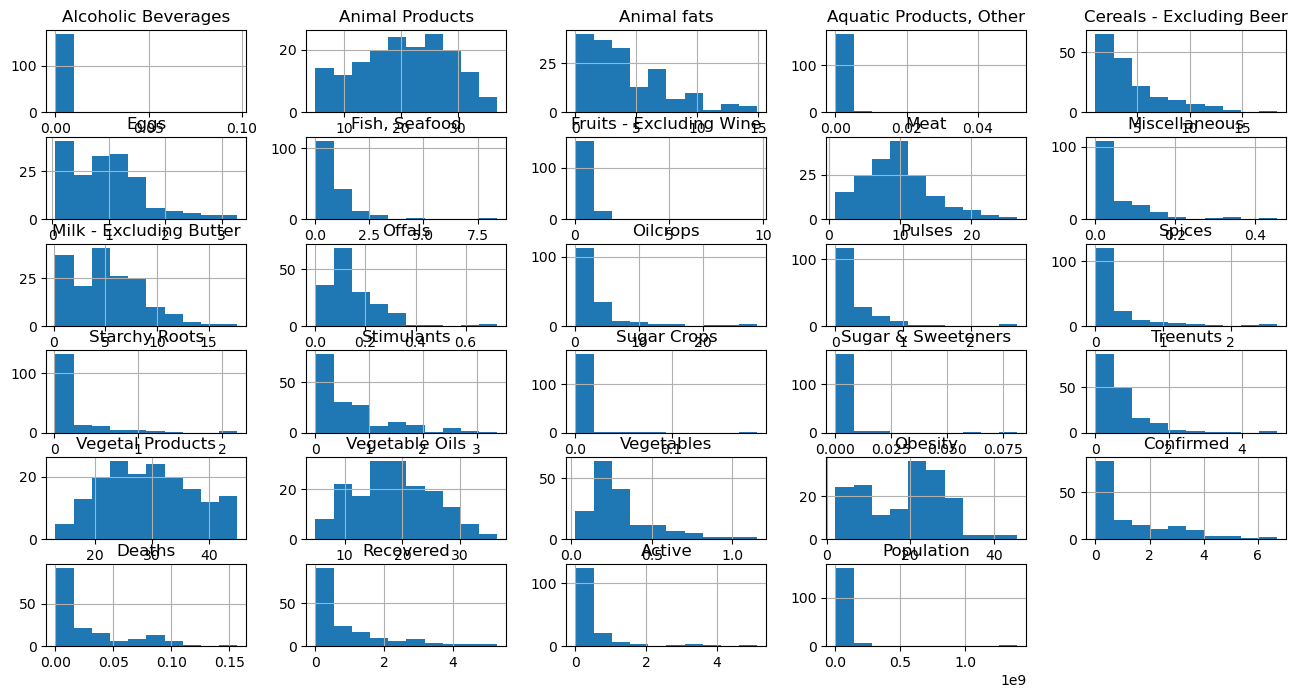

In [16]:
df.hist(figsize=(16,8))

In [17]:
columns_to_drop = ['Alcoholic Beverages',
                   'Aquatic Products, Other',
                   'Animal Products',
                   'Miscellaneous',
                   'Offals',
                   'Spices',
                   'Vegetable Oils',
                   'Sugar Crops',
                   'Vegetables',
                   'Population']

df = df.drop(columns=columns_to_drop)

<Axes: >

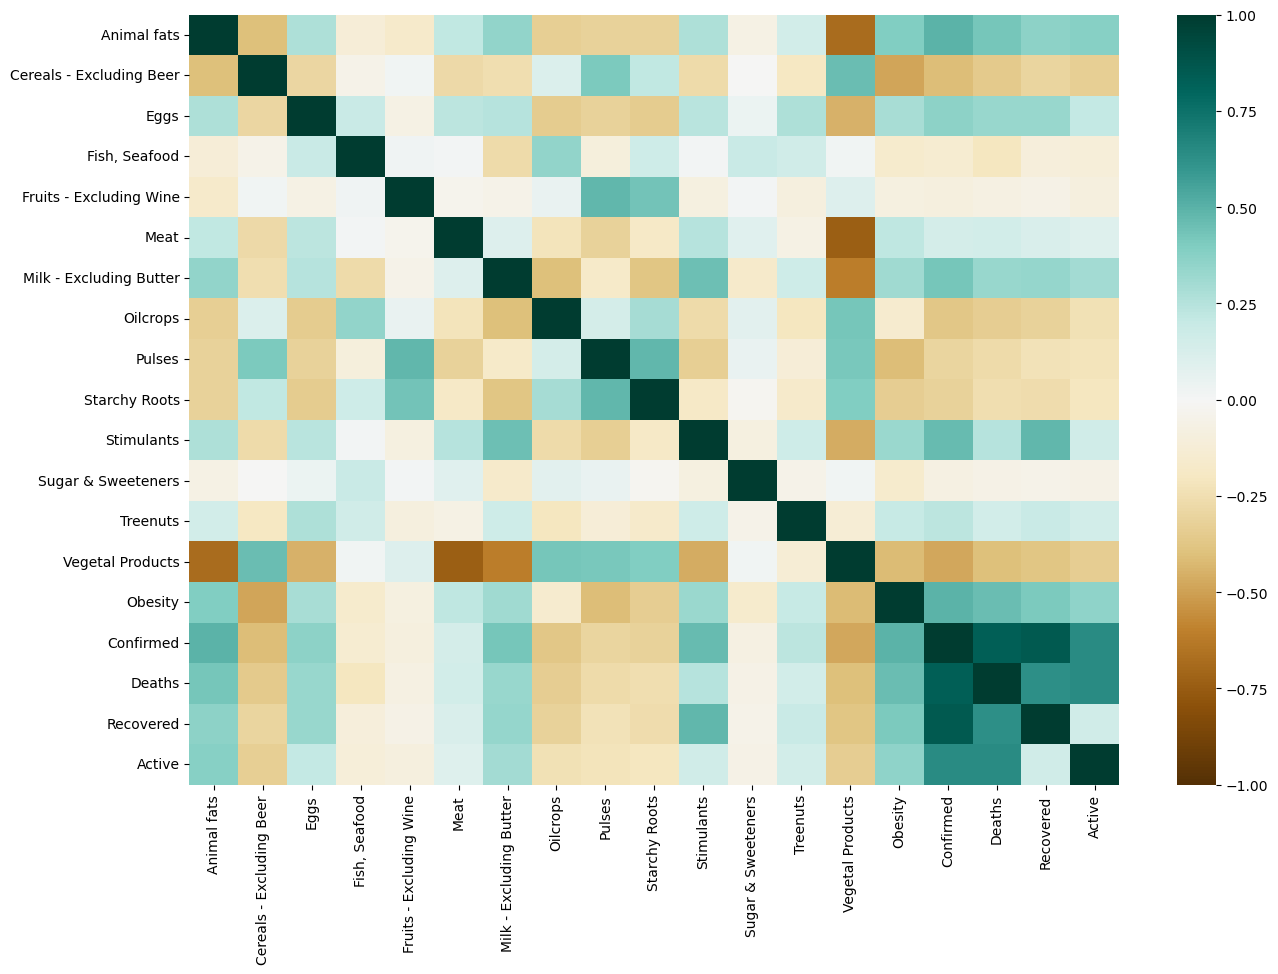

In [18]:
plt.figure(figsize=(15,10))
sns.heatmap(df.select_dtypes(include=np.number).corr(), vmin=-1, vmax=1, annot=False,cmap='BrBG')

 ## Data Exploration and Processing

Now let's explore the dataset:
- check the head
- the columns
- the variable types

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Country                   170 non-null    object 
 1   Animal fats               170 non-null    float64
 2   Cereals - Excluding Beer  170 non-null    float64
 3   Eggs                      170 non-null    float64
 4   Fish, Seafood             170 non-null    float64
 5   Fruits - Excluding Wine   170 non-null    float64
 6   Meat                      170 non-null    float64
 7   Milk - Excluding Butter   170 non-null    float64
 8   Oilcrops                  170 non-null    float64
 9   Pulses                    170 non-null    float64
 10  Starchy Roots             170 non-null    float64
 11  Stimulants                170 non-null    float64
 12  Sugar & Sweeteners        170 non-null    float64
 13  Treenuts                  170 non-null    float64
 14  Vegetal Pr

In [20]:
df.head()

,Country,Animal fats,Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,Milk - Excluding Butter,Oilcrops,Pulses,...,Stimulants,Sugar & Sweeteners,Treenuts,Vegetal Products,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active
0,Afghanistan,6.2224,8.0353,0.6859,0.0327,0.4246,6.1244,8.2803,1.0452,0.1960,...,0.0980,0.0,0.7513,28.3684,4.5,29.8,0.125149,0.005058,0.098263,0.021827
1,Albania,3.4172,2.6734,1.6448,0.1445,0.6418,8.7428,17.7576,3.1622,0.1148,...,0.5270,0.0,0.9181,17.9998,22.3,6.2,1.733298,0.035800,0.874560,0.822939
2,Algeria,0.8972,4.2035,1.2171,0.2008,0.5772,3.8961,8.0934,1.1983,0.2698,...,0.2886,0.0,0.8595,35.5857,26.6,3.9,0.208754,0.005882,0.137268,0.065604
3,Angola,1.3130,6.5545,0.1539,1.4155,0.3488,11.0268,1.2309,3.9902,0.3282,...,0.1128,0.0,0.0308,34.7010,6.8,25,0.050049,0.001144,0.027440,0.021465
4,Antigua and Barbuda,4.6686,3.2153,0.3872,1.5263,1.2177,14.3202,6.6607,1.3579,0.0673,...,1.0549,0.0,0.2020,22.2995,19.1,NaN,0.151020,0.005102,0.140816,0.005102


In [21]:
df.columns

Index(['Country', 'Animal fats', 'Cereals - Excluding Beer', 'Eggs',
       'Fish, Seafood', 'Fruits - Excluding Wine', 'Meat',
       'Milk - Excluding Butter', 'Oilcrops', 'Pulses', 'Starchy Roots',
       'Stimulants', 'Sugar & Sweeteners', 'Treenuts', 'Vegetal Products',
       'Obesity', 'Undernourished', 'Confirmed', 'Deaths', 'Recovered',
       'Active'],
      dtype='object')

Let's create a function to **check missing data** and unveil **the percentage of data missing** for each dataframe

In [22]:
def missing_data(df):  
    return df.isnull().sum() * 100 / len(df)

In [23]:
df.Undernourished = pd.to_numeric(df.Undernourished, errors='coerce')

Delete the countries for which values are missing.

In [24]:
df = df.dropna(axis=0, how='any')
missing_data(df)

Country                     0.0
Animal fats                 0.0
Cereals - Excluding Beer    0.0
Eggs                        0.0
Fish, Seafood               0.0
Fruits - Excluding Wine     0.0
Meat                        0.0
Milk - Excluding Butter     0.0
Oilcrops                    0.0
Pulses                      0.0
Starchy Roots               0.0
Stimulants                  0.0
Sugar & Sweeteners          0.0
Treenuts                    0.0
Vegetal Products            0.0
Obesity                     0.0
Undernourished              0.0
Confirmed                   0.0
Deaths                      0.0
Recovered                   0.0
Active                      0.0
dtype: float64

In [25]:
missing_data(df)

Country                     0.0
Animal fats                 0.0
Cereals - Excluding Beer    0.0
Eggs                        0.0
Fish, Seafood               0.0
Fruits - Excluding Wine     0.0
Meat                        0.0
Milk - Excluding Butter     0.0
Oilcrops                    0.0
Pulses                      0.0
Starchy Roots               0.0
Stimulants                  0.0
Sugar & Sweeteners          0.0
Treenuts                    0.0
Vegetal Products            0.0
Obesity                     0.0
Undernourished              0.0
Confirmed                   0.0
Deaths                      0.0
Recovered                   0.0
Active                      0.0
dtype: float64

Look at the different data types for each variable.

Explore the variables that are not of float type and see of you can convert them in to float type.

# Clustering

## Data preparation

In [652]:
numerical_features = df.select_dtypes(include=np.number).columns.to_list()
categorical_features = df.select_dtypes(exclude=np.number).columns.to_list()

Scale the dataset

In [610]:
numerical_transformer = Pipeline([
    # ('imputer', KNNImputer(n_neighbors=5)),
    #('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    #('num_imputer', SimpleImputer(strategy='constant', fill_value=0))
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    # ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    
])

preprocessor = ColumnTransformer([
        ("numerical", numerical_transformer,numerical_features),
        #("categorical", categorical_transformer,categorical_features)
        
])

df_transformed = preprocessor.fit_transform(df)

In [613]:
df_transformed = pd.DataFrame(df_transformed, columns=numerical_features)

In [ ]:

# Reorder the columns to have 'Country' as the first column
df_transformed = df_transformed[['Country'] + numerical_features]


In [570]:
X = df_transformed.drop(columns=['Deaths'])
y = df_transformed['Deaths']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3)

categorical_features = X_train.select_dtypes(exclude=np.number).columns.to_list()
numerical_features = X_train.select_dtypes(include=np.number).columns.to_list()

## Plot some data

Now, we want to visualize some variables for each state. To do so, we use plotly express to have the possibility to hover on a scatter plot and see the statistics per country clearer as explained here.

https://plotly.com/python/hover-text-and-formatting/#:~:text=Basic%20Charts%20tutorials.-,Hover%20Labels,having%20a%20hover%20label%20appear.

Plot the "Obesity" vs "Deaths" statistics

In [653]:
fig = px.line(df, x="Obesity", y="Deaths", color="Country", title='"Obesity" vs "Deaths" statistics')
fig.update_traces(mode="markers+lines")

fig.show()

Plot the "Animal fats" vs "Deaths" statistics

In [654]:
fig = px.line(df, x="Animal fats", y="Deaths", color="Country", title='"Animal fats" vs "Deaths" statistics')
fig.update_traces(mode="markers+lines")

fig.show()

## K-means and Elbow method

We start with the K-Means model:
- use the scikit-learn method
- use the method you implemented.

Use a graphical tool, the elbow method, to estimate the optimal number of clusters k for a given task.
- Determine the optimal number of clusters for the previous 2 plots.

c:\Users\eduard.vlasov\AppData\Local\anaconda3\envs\arbres\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\eduard.vlasov\AppData\Local\anaconda3\envs\arbres\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\eduard.vlasov\AppData\Local\anaconda3\envs\arbres\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\eduard.vlasov\AppData\Local\anaconda3\envs\arbres\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL

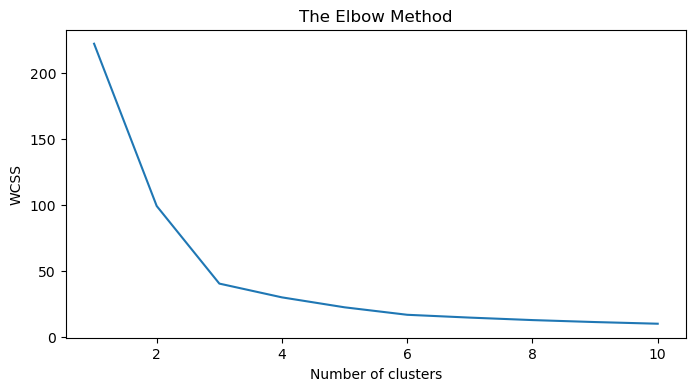

In [675]:
X = df[['Obesity',  'Deaths']].values

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
figure = plt.gcf()
figure.set_size_inches(8, 4)

plt.show()

Plot the obtained clusters

c:\Users\eduard.vlasov\AppData\Local\anaconda3\envs\arbres\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\eduard.vlasov\AppData\Local\anaconda3\envs\arbres\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



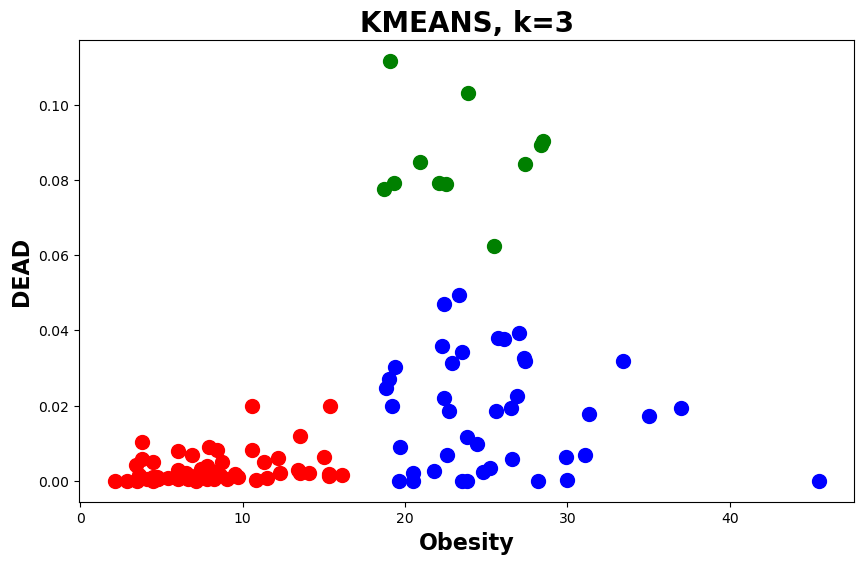

In [676]:
k=3

# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X_scaled)
dataset =df[['Obesity',  'Deaths']].copy()
original_len=dataset.shape[0]
for i in range(0,original_len):
    dataset.loc[i,"Cluster"]=y_kmeans[i]
    
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')   
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')




plt.title('KMEANS, k=3',fontsize=20, fontweight='bold')
plt.xlabel('Obesity',fontsize=16, fontweight='bold')
plt.ylabel('DEAD',fontsize=16, fontweight='bold')

figure = plt.gcf()
figure.set_size_inches(10, 6)
plt.show()

c:\Users\eduard.vlasov\AppData\Local\anaconda3\envs\arbres\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\eduard.vlasov\AppData\Local\anaconda3\envs\arbres\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\eduard.vlasov\AppData\Local\anaconda3\envs\arbres\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\eduard.vlasov\AppData\Local\anaconda3\envs\arbres\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL

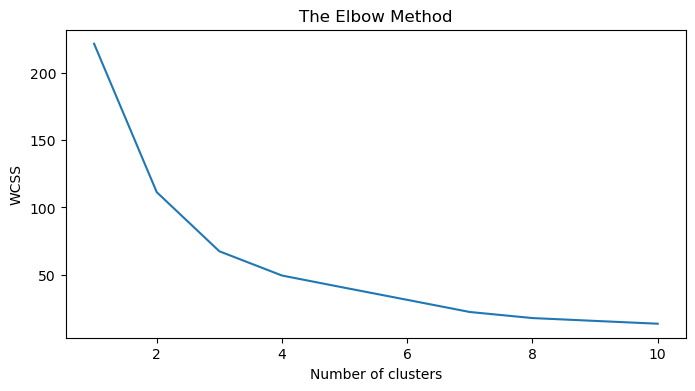

In [677]:
X = df[['Animal fats',  'Deaths']].values

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
figure = plt.gcf()
figure.set_size_inches(8, 4)

plt.show()

c:\Users\eduard.vlasov\AppData\Local\anaconda3\envs\arbres\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\eduard.vlasov\AppData\Local\anaconda3\envs\arbres\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



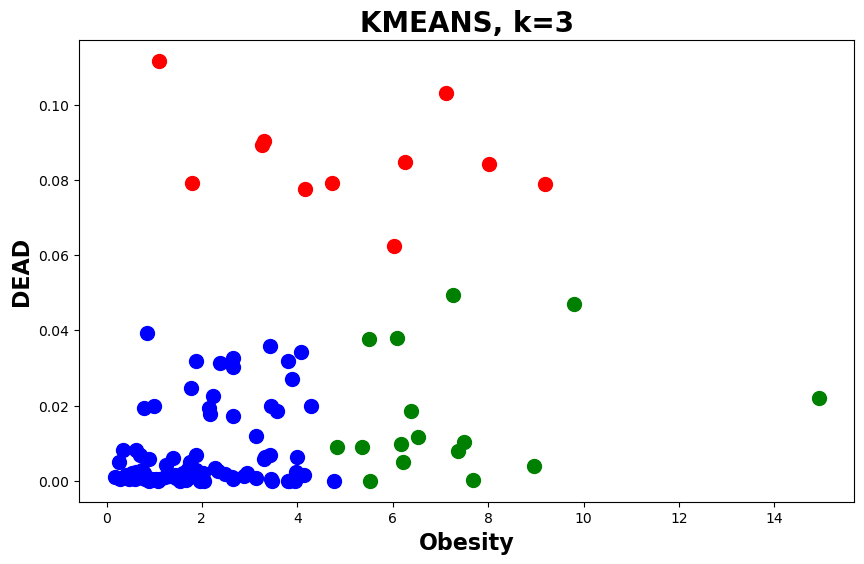

In [678]:
k=3

# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X_scaled)
dataset =df[['Animal fats', 'Deaths']].copy()
original_len=dataset.shape[0]
for i in range(0,original_len):
    dataset.loc[i,"Cluster"]=y_kmeans[i]
    
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Cluster 1')   
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Cluster 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')




plt.title('KMEANS, k=3',fontsize=20, fontweight='bold')
plt.xlabel('Obesity',fontsize=16, fontweight='bold')
plt.ylabel('DEAD',fontsize=16, fontweight='bold')

figure = plt.gcf()
figure.set_size_inches(10, 6)
plt.show()

## Other clustering methods

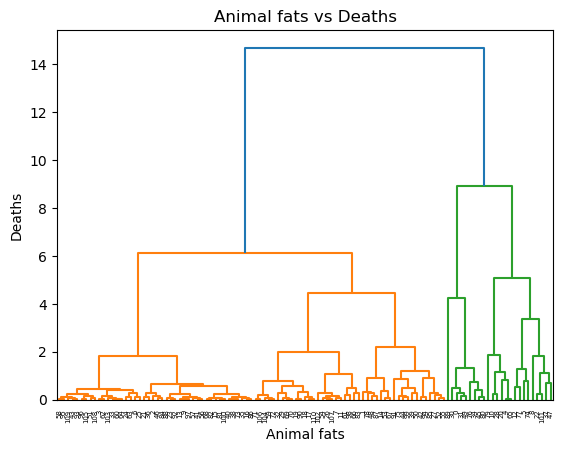

In [687]:
# Hierarchical Clustering
from scipy.cluster.hierarchy import dendrogram, linkage

X = df[['Animal fats',  'Deaths']].values

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

linkage_data = linkage(X_scaled, method='ward', metric='euclidean')
dendrogram(linkage_data)

plt.title("Animal fats vs Deaths")
plt.xlabel("Animal fats")
plt.ylabel("Deaths")

plt.show()

c:\Users\eduard.vlasov\AppData\Local\anaconda3\envs\arbres\Lib\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead



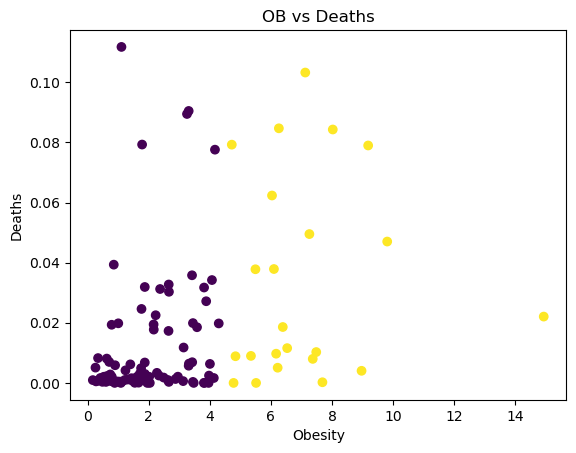

In [689]:
from sklearn.cluster import AgglomerativeClustering

hierarchical_cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
labels = hierarchical_cluster.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=labels)

plt.title("OB vs Deaths")
plt.xlabel("Obesity")
plt.ylabel("Deaths")

plt.show()

We are going to explore other clustering methods, such as Mean-Shift.

You can read more about it in the next ressource:
https://scikit-learn.org/stable/modules/clustering.html


Apply the method to our datasets made of 2 variables ("Obesity" vs "Deaths")

In [691]:
# Mean-Shift
from sklearn.cluster import MeanShift, estimate_bandwidth

X = df[['Obesity',  'Deaths']].values

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

ms = MeanShift()
ms.fit(X_scaled)



MeanShift()

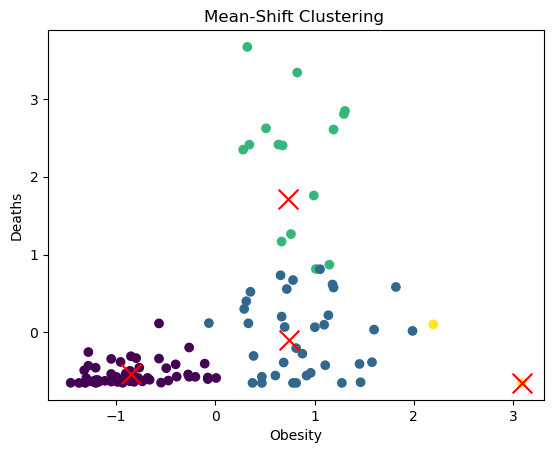

In [695]:
labels = ms.labels_
centers = ms.cluster_centers_

plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels)
plt.scatter(centers[:, 0], centers[:, 1], marker='x', color='red', s=200)
plt.xlabel('Obesity')
plt.ylabel('Deaths')
plt.title('Mean-Shift Clustering ')
plt.show()

Check out other algorithms such as DBSAN or OPTICS, why are these algorithms very interesting and in what cases? 

['y', 'b', 'g', 'r']


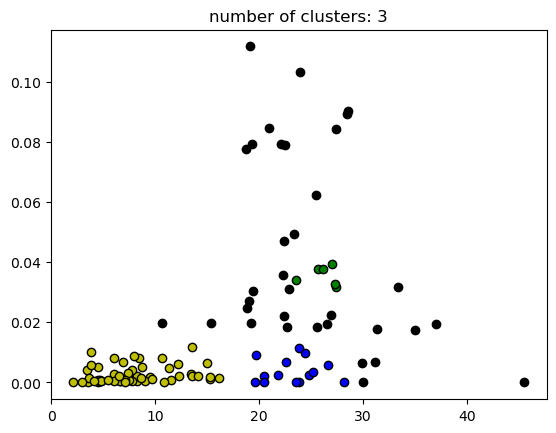

In [705]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.3, min_samples=5).fit(X_scaled)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
 
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
 
# Plot result
 
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = ['y', 'b', 'g', 'r']
print(colors)
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'
 
    class_member_mask = (labels == k)
 
    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k',
             markersize=6)
 
    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k',
             markersize=6)
 
plt.title('number of clusters: %d' % n_clusters_)
plt.show()

# Regression and prediction

Given this dataset and the emphasis we have already laid on deaths through clustering, it would be interesting to study this dataset for a classification purpose and see how accurately we can predict the mortality rate in fonction of the given features.

## Creating train and test sets 

Let's separate the data into a training and testing sets using random selection.

In [55]:
df1 = df.drop(columns=['Country'])
columns = df1.columns


scaler= StandardScaler().fit(df1)
df1 = scaler.fit_transform(df1)

df_transformed = pd.DataFrame(df1, columns=columns)

In [57]:
X = df_transformed.drop(columns=['Deaths', 'Confirmed', 'Recovered', 'Active'])
y = df_transformed['Deaths']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3)

## Random Forest

Let's try a random forest model on the prepared fat_quantity training set.

In [58]:
grid = { 
    'n_estimators': [25,50,100],
    'max_depth' : [5,10,15],
    'random_state' : [10]
}

CV_rfr = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid, cv= 5)
CV_rfr.fit(X_train, y_train)

print("Best hyperparameters: ", CV_rfr.best_params_)
print("Best validation f1: ", CV_rfr.best_score_)

Best hyperparameters:  {'max_depth': 10, 'n_estimators': 100, 'random_state': 10}
Best validation f1:  0.27282930694965496


In [59]:
rf = RandomForestRegressor(max_depth= 5, n_estimators= 100, random_state= 10)
rf.fit(X_train, y_train)

Now we predict.

In [62]:
y_pred = rf.predict(X_test) 
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred)) 

RMSE:  1.4562636324955351


Let's perform a 10 fold cross validation.
And display the resulting scores:

In [79]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
rf = RandomForestRegressor()
scores = cross_val_score(rf, X_test, y_test, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
scores
#print('RMSE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

array([-0.33252482, -1.42959631, -0.51176245, -0.94109355, -1.88585267,
       -0.97268621, -0.82624148, -0.95162646, -0.59731862, -0.206698  ])

## Learning Curves analysis 

Use the function seen in **Module 1 to plot learning curves with cross validation.** 

In [66]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, test_size=0.3)
    
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(10, 6))
    axes.set_title(title)
    
    if ylim is not None:
        axes.set_ylim(*ylim)
        
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores, _, _ = learning_curve(
        estimator, 
        X_train, 
        y_train, 
        cv=cv, 
        n_jobs=n_jobs, 
        train_sizes=train_sizes, 
        return_times=True,
        scoring='accuracy'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    axes.grid()
    
    axes.fill_between(
        train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1,
        color="b"
    )
    axes.fill_between(
        train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1,
        color="r"
    )
    axes.plot(train_sizes, train_scores_mean, 'o-', color="b", label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="r", label="Accuracy score")
    axes.legend(loc="best")

    return axes

Try to interpret the obtained learning curve.

In [ ]:
plot_learning_curve(rf, 'rf', X, y, cv=10)

## SVM

Use the SVM regressor to estimate the death rate. See if you can get a better model than with the Random forest regressor.

In [76]:
from sklearn.svm import SVR

svr = SVR()
svr.fit(X_train, y_train)

y_pred_svc = svr.predict(X_test)
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred_svc)) 

RMSE:  1.3789611882136754


In [77]:
grid = {'C':np.arange(1, 1000, 20),
        'gamma': np.logspace(-8, np.log10(40), 50)
}

CV_svr = GridSearchCV(estimator=SVR(), param_grid=grid, cv= 5)
CV_svr.fit(X_train, y_train)

print("Best hyperparameters: ", CV_svr.best_params_)
print("Best validation f1: ", CV_svr.best_score_)

Best hyperparameters:  {'C': 21, 'gamma': 0.17804717836025374}
Best validation f1:  0.4362632862610864


In [81]:
svr = SVR(C=21, gamma= 0.17804717836025374)
svr.fit(X_train, y_train)

y_pred_svc = svr.predict(X_test)
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred_svc)) 

RMSE:  1.171758519053382


## Linear regression

In [82]:
reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred_lr = reg.predict(X_test)
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred_lr)) 

RMSE:  1.9523253639100364


In [84]:
grid = {'n_jobs':[-1,1,5,10,20,50]
}

CV_reg = GridSearchCV(estimator=LinearRegression(), param_grid=grid, cv= 5)
CV_reg.fit(X_train, y_train)

print("Best hyperparameters: ", CV_reg.best_params_)
print("Best validation f1: ", CV_reg.best_score_)

Best hyperparameters:  {'n_jobs': -1}
Best validation f1:  0.15092249478595934


In [85]:
reg = LinearRegression(n_jobs=-1)
reg.fit(X_train, y_train)

y_pred_lr = reg.predict(X_test)
print("RMSE: ", metrics.mean_squared_error(y_test, y_pred_lr)) 

RMSE:  1.9523253639100364


# Dimensionality reduction

Let's take a look at the whole dataset and see if there are any clusters.

In order to do these perform and plot a PCA of 2 components.

Dimensionality reduction is a way to reduce the number of features in your dataset without having to lose much information and keep the model’s performance. Check out the Random Forest based method and PCA for dimensionality reduction in the following ressource:

https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/

In [99]:
from sklearn.decomposition import PCA

df[['Obesity','Deaths']]


,Obesity,Deaths
0,4.5,0.005058
1,22.3,0.035800
2,26.6,0.005882
3,6.8,0.001144
5,28.5,0.090444
...,...,...
165,25.2,0.003351
166,2.1,0.000036
167,14.1,0.002032
168,6.5,0.001996


(-0.001, 0.1)

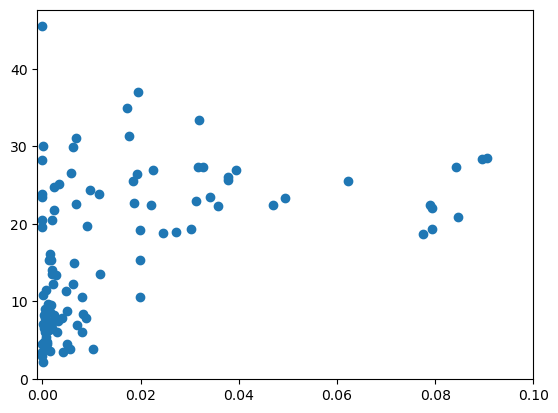

In [103]:

plt.scatter(df['Deaths'], df['Obesity'])
plt.xlim(-0.001,  0.1)


In [95]:
pca = PCA(n_components=2)
pca.fit(df[['Obesity','Deaths']])

print(pca.components_)

[[ 0.99999927  0.00120494]
 [-0.00120494  0.99999927]]


## Random Forest feature selection

In [97]:
rf = RandomForestRegressor(max_depth= 5, n_estimators= 100, random_state= 10)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
feature_names = X_train.columns
indices = np.argsort(importances)[::-1]


print("Feature ranking:")
for f in range(len(indices)):
    print(f"{f + 1}. {feature_names[indices[f]]} ({importances[indices[f]]})")

Feature ranking:
1. Animal fats (0.363722803504581)
2. Obesity (0.17462595227455474)
3. Fish, Seafood (0.07339495940862777)
4. Eggs (0.06893969785609794)
5. Oilcrops (0.05819232264759943)
6. Stimulants (0.041165395841681364)
7. Fruits - Excluding Wine (0.03920970083919626)
8. Treenuts (0.03505658741864723)
9. Cereals - Excluding Beer (0.03076719506915333)
10. Pulses (0.026167054867843747)
11. Starchy Roots (0.025908795814413143)
12. Undernourished (0.02022112968682778)
13. Milk - Excluding Butter (0.02005556519071421)
14. Vegetal Products (0.01531705404031408)
15. Meat (0.007057384029141866)
16. Sugar & Sweeteners (0.00019840151060610618)


Plot the feature importance graph.

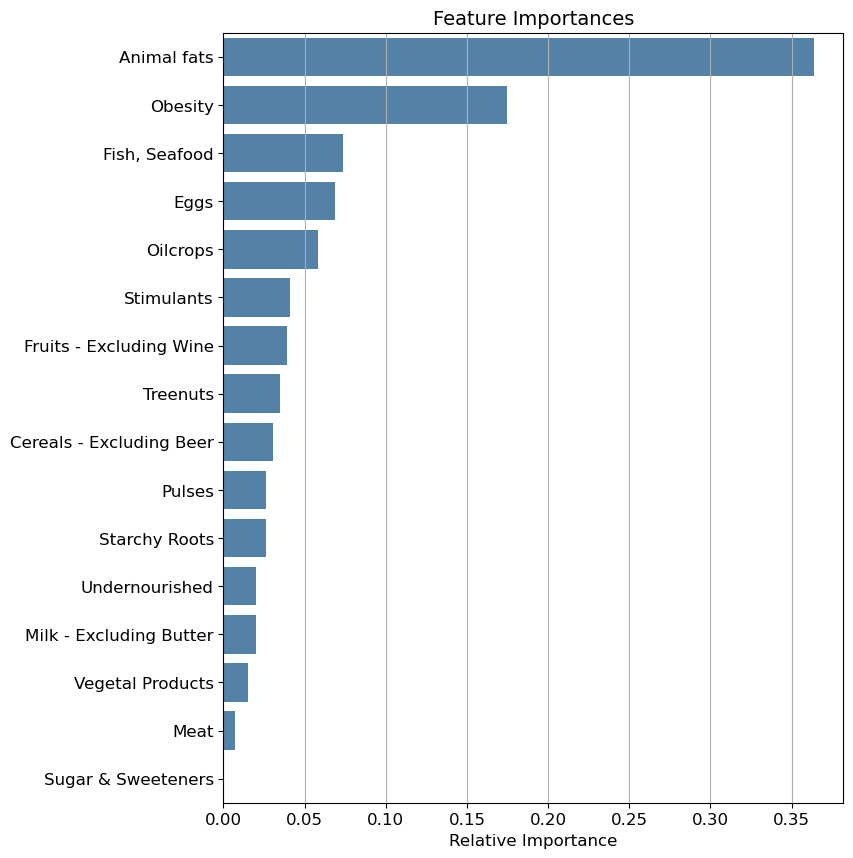

In [98]:
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 10))
plt.title("Feature Importances", fontsize=14)
sns.barplot(x=importances[indices], y=feature_names[indices], color='steelblue')
plt.xlabel("Relative Importance", fontsize=12)
plt.grid(True, axis='x')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

Comment the graph.

## PCA dimensionality reduction

PCA is a technique which helps us in extracting a new set of variables from an existing large set of variables. Apply clustering methods on this new set of variables. Are the clusters obtained different than the clusters obtained on the "Obesity" vs "Deaths"?

Apply the Elbow method to determne the right number of clusters.

Use diverse methods to cluster the countries.